In [93]:
import os
import time
import torch
from torch.nn import Linear
import torch.nn.functional as F

os.environ['TORCH_VERSION'] = torch.__version__
print(torch.__version__)

from torch_geometric.datasets import KarateClub, Planetoid, TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

2.0.1


In [3]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap="Set2")
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()

In [7]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [9]:
data = dataset[0]
print(data)
print('============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [17]:
print(data.edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

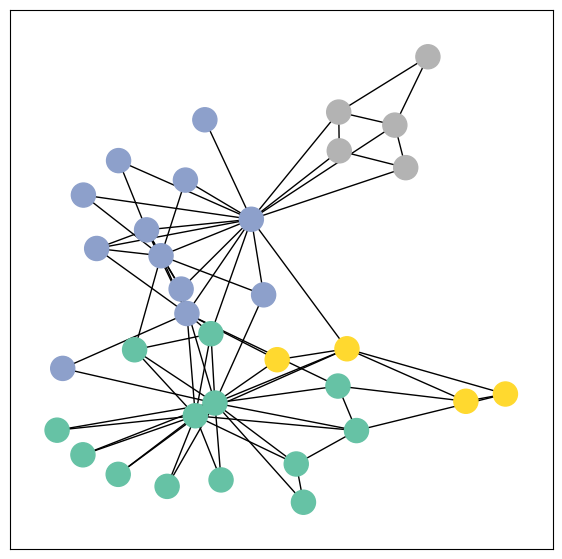

In [20]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [22]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


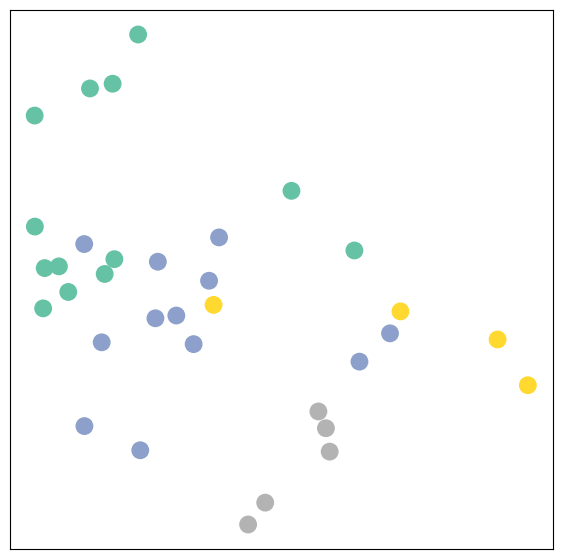

In [34]:
out, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

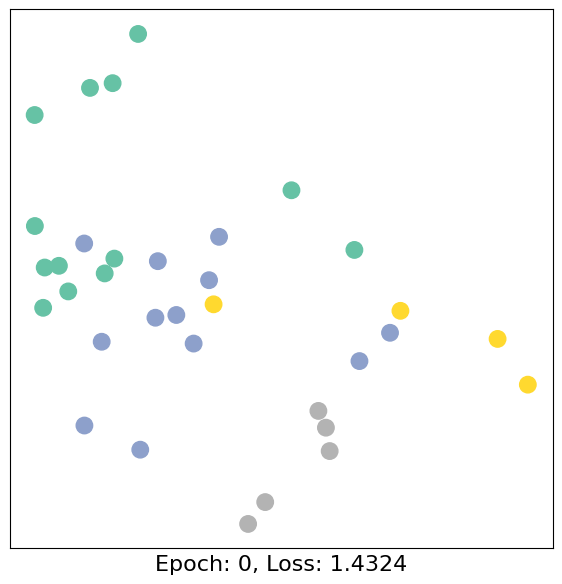

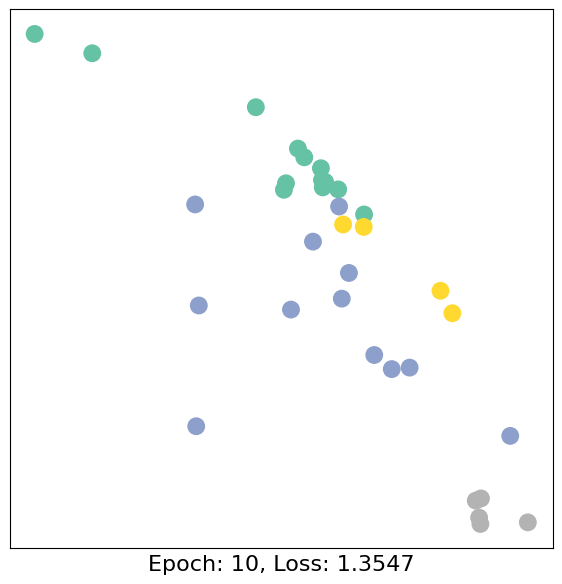

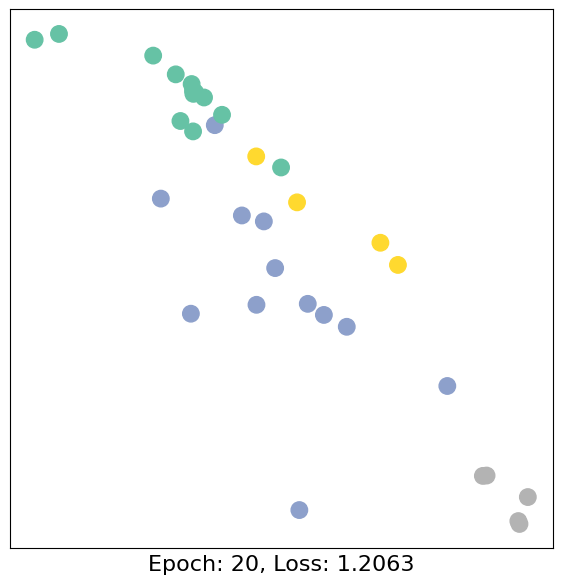

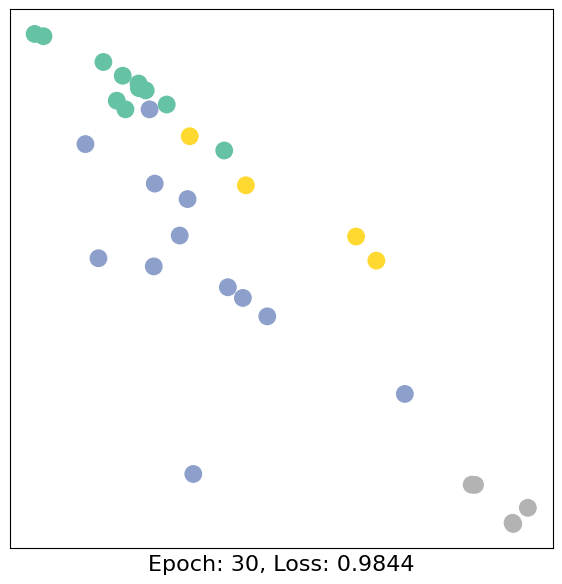

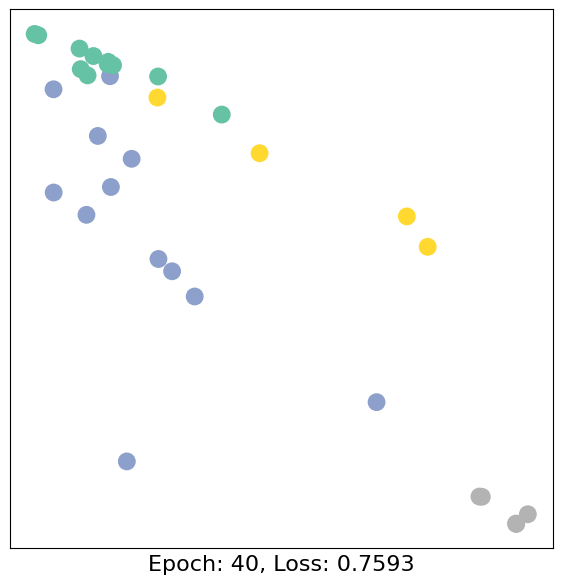

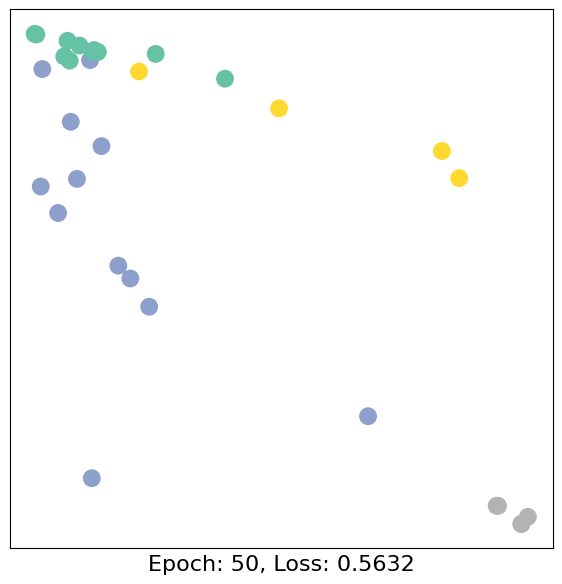

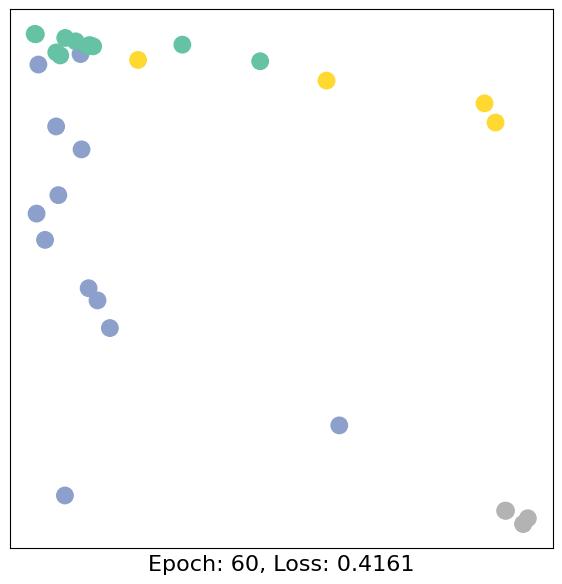

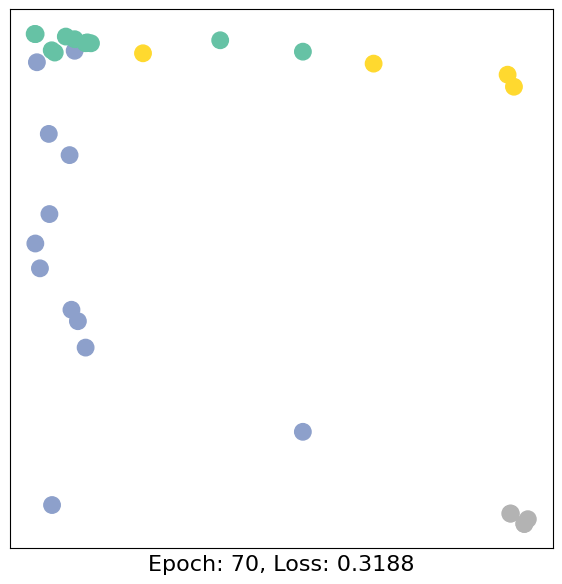

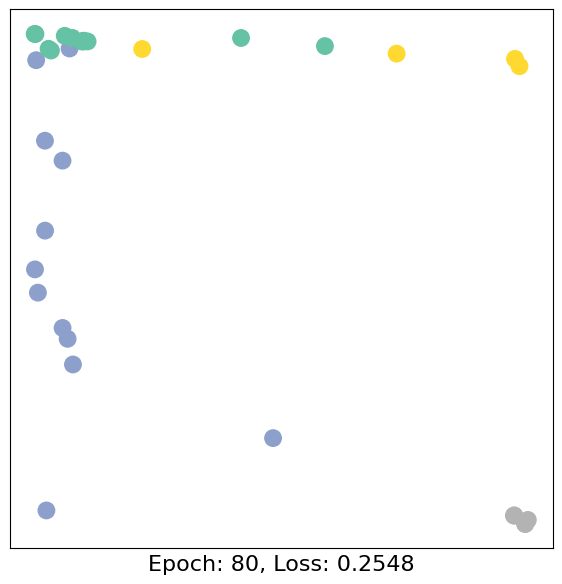

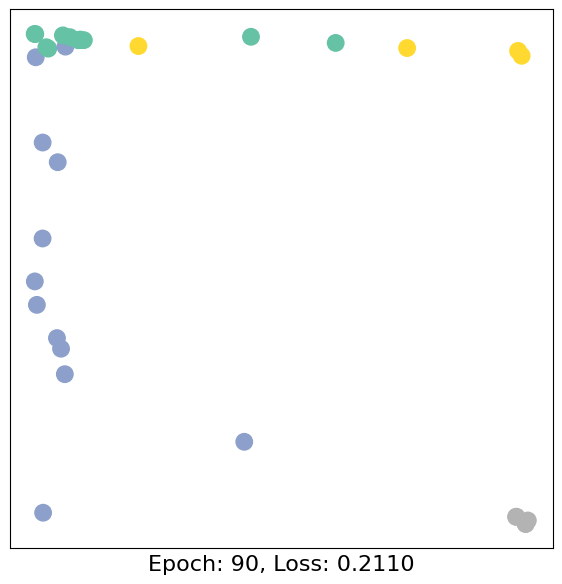

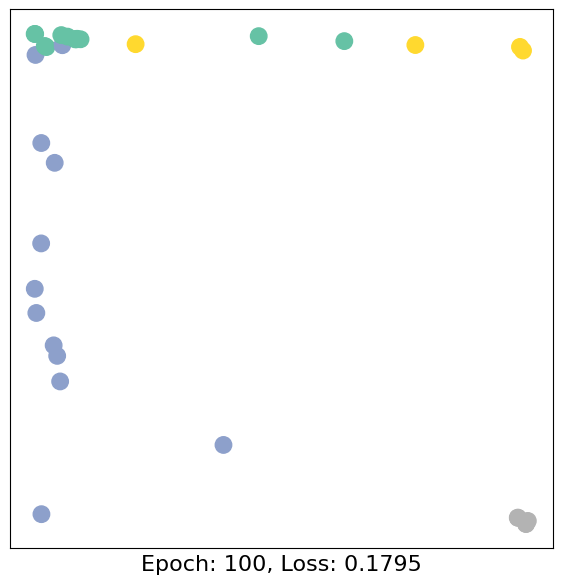

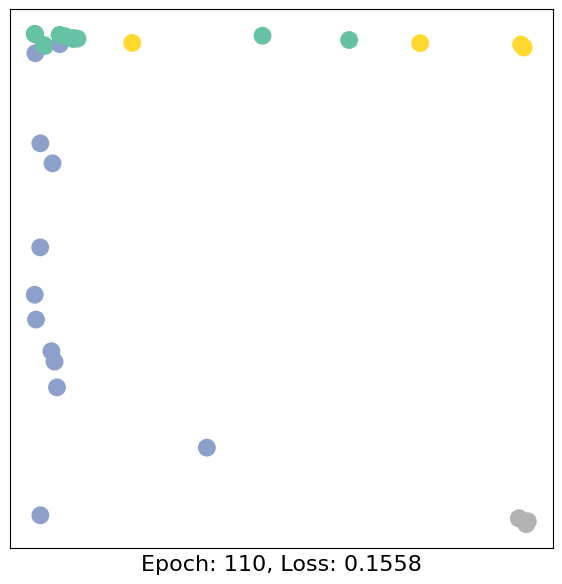

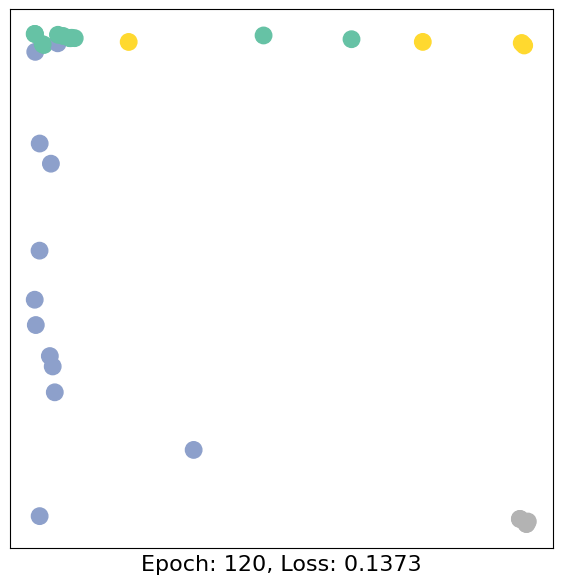

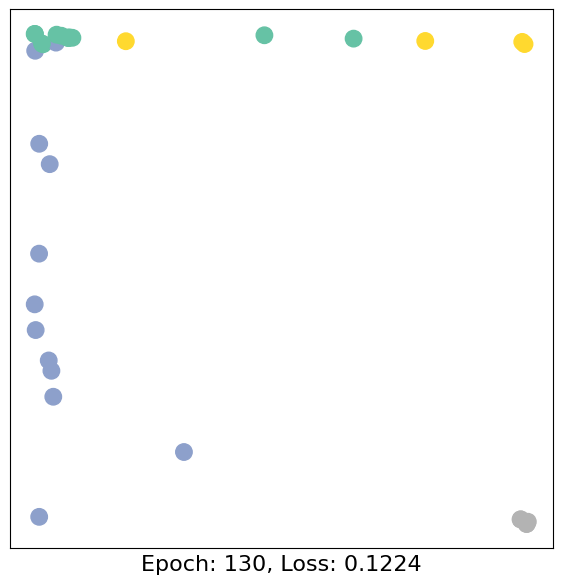

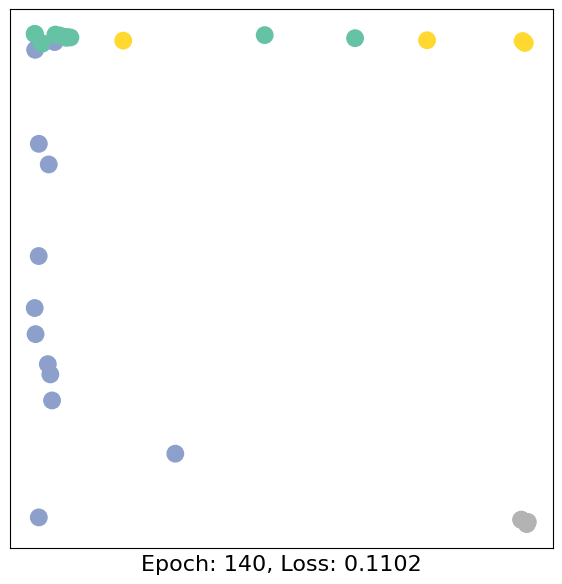

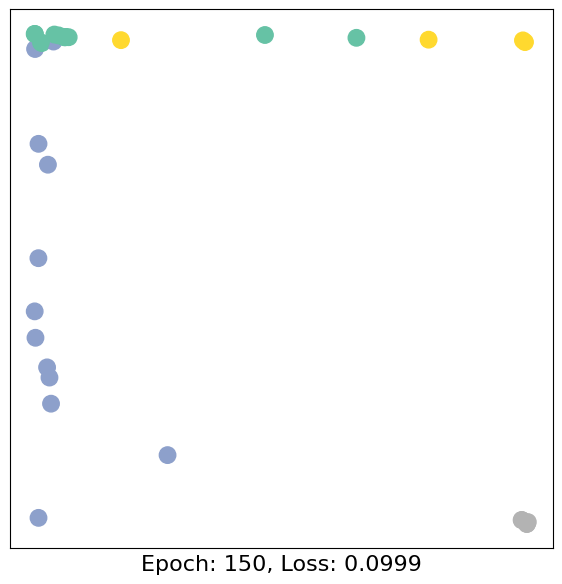

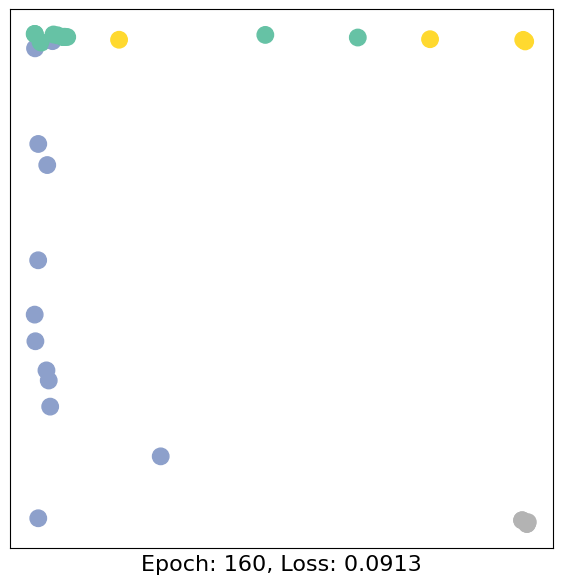

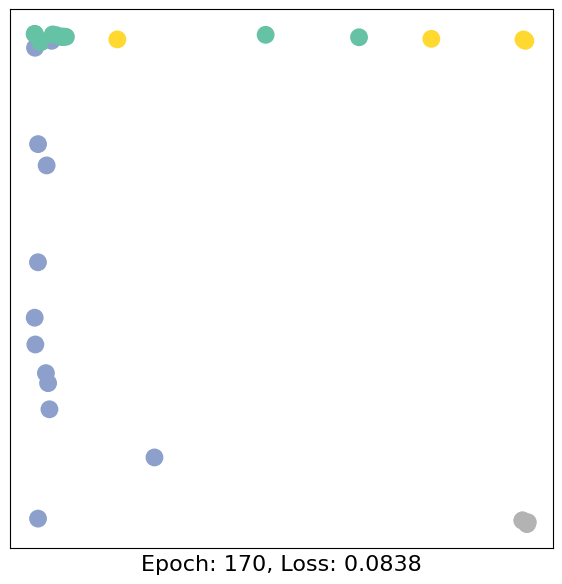

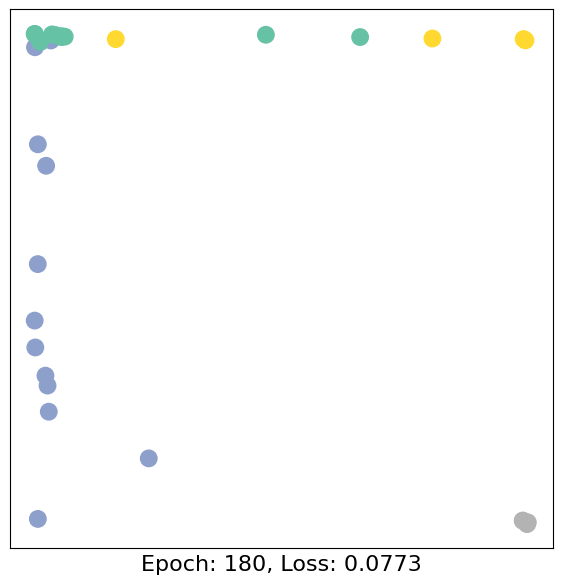

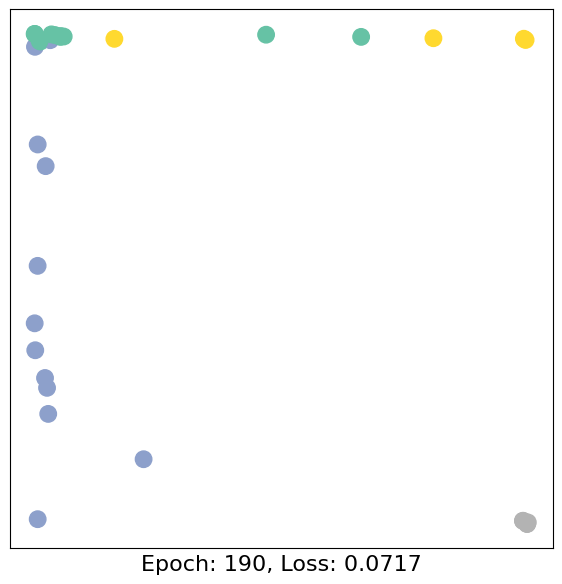

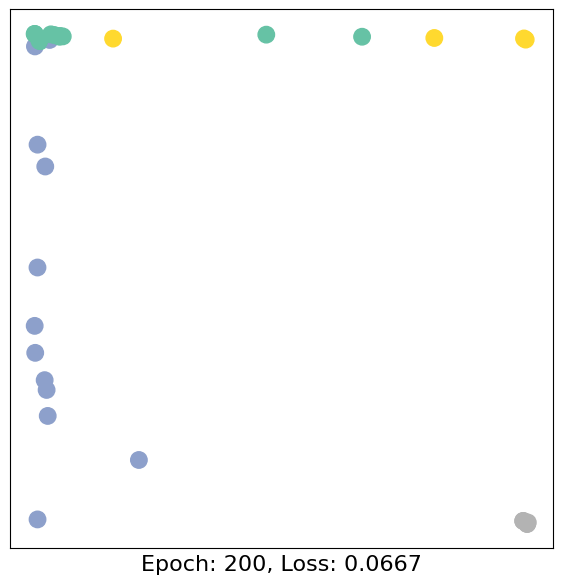

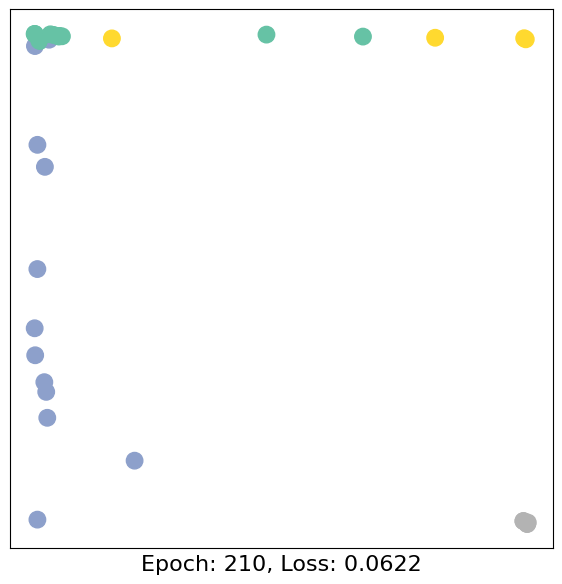

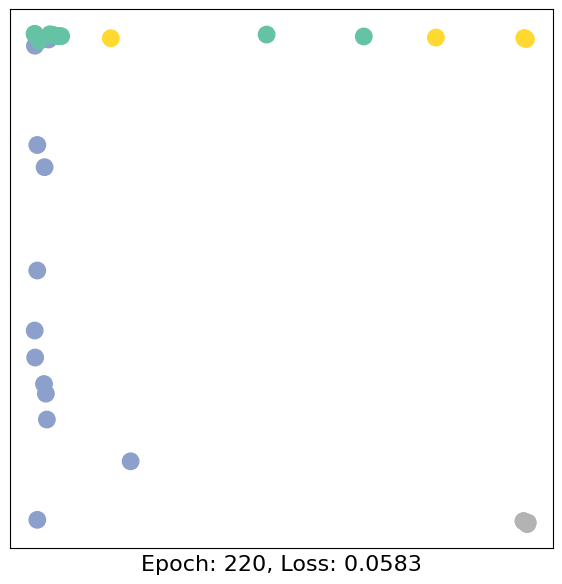

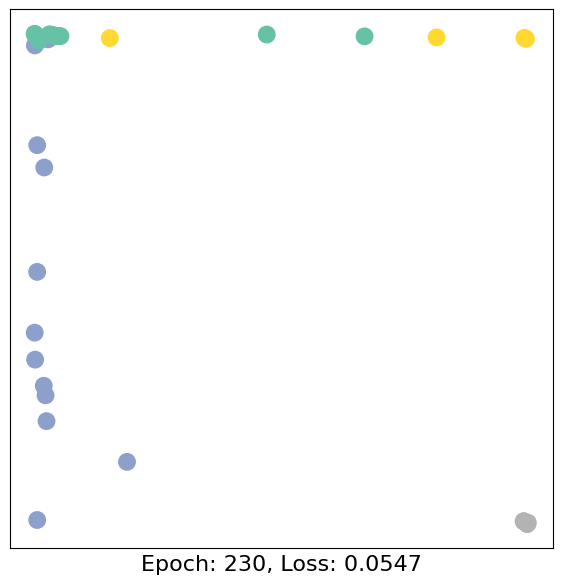

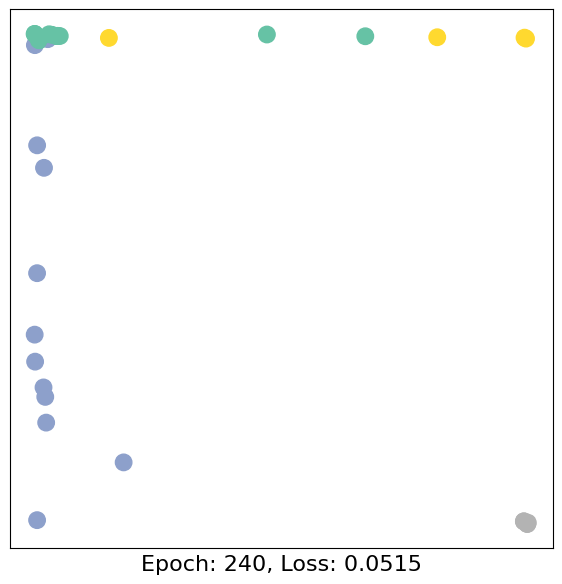

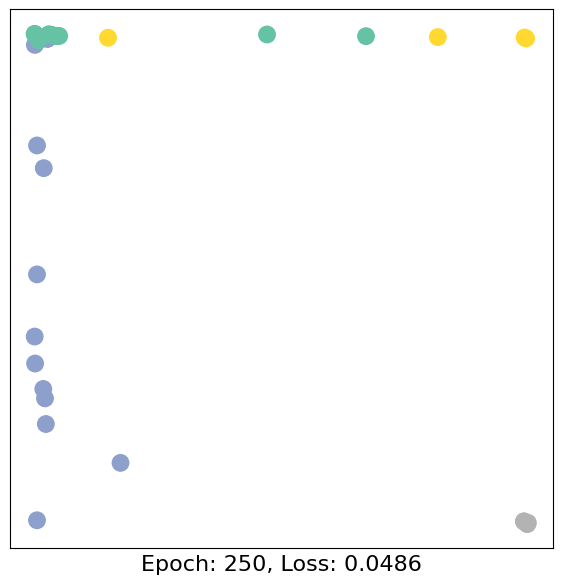

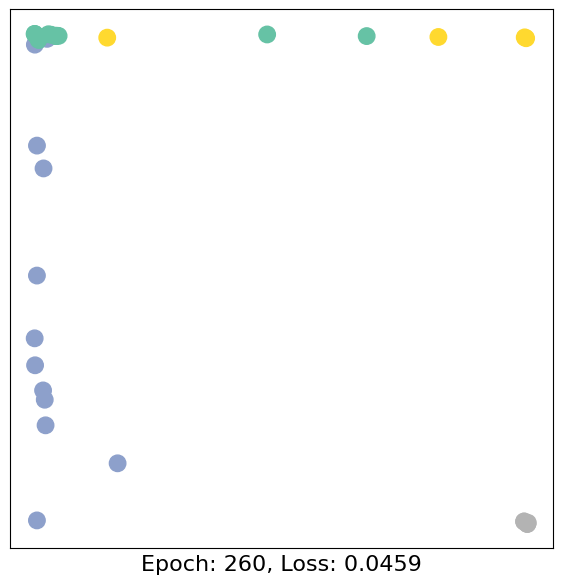

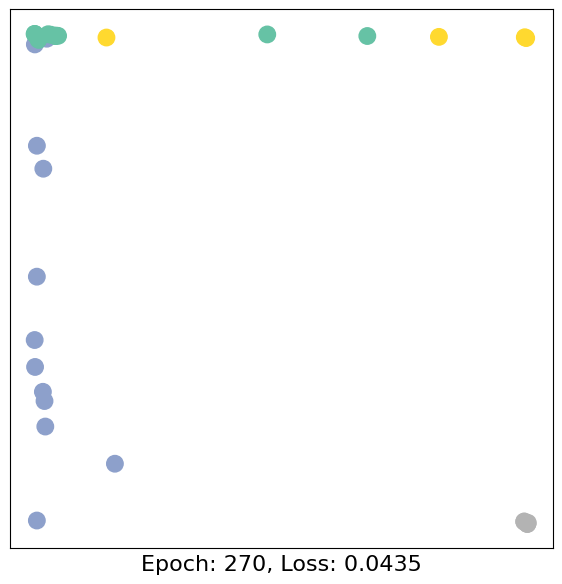

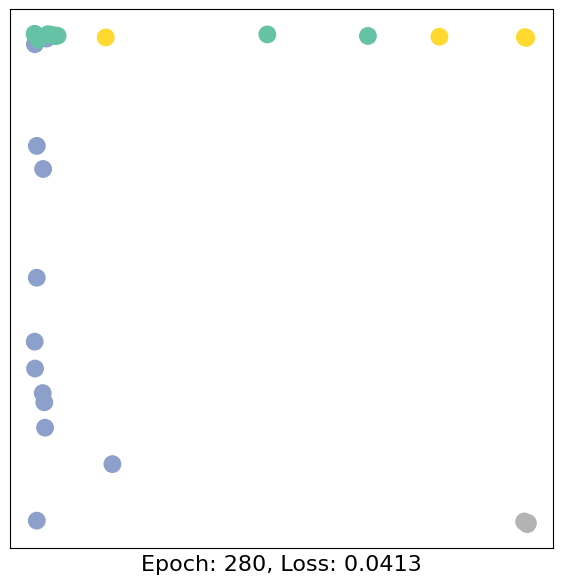

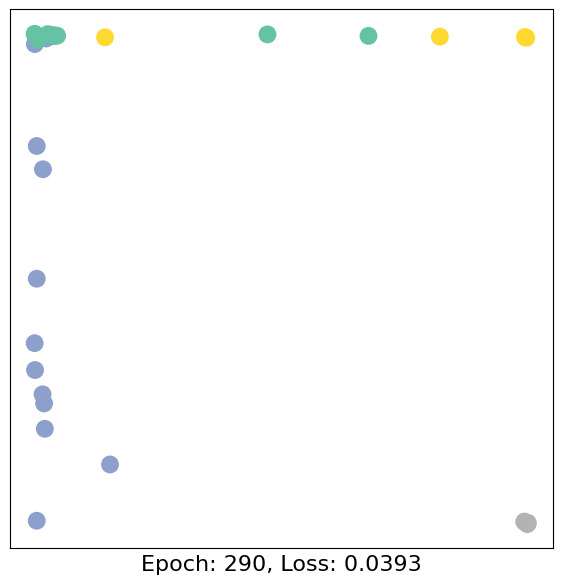

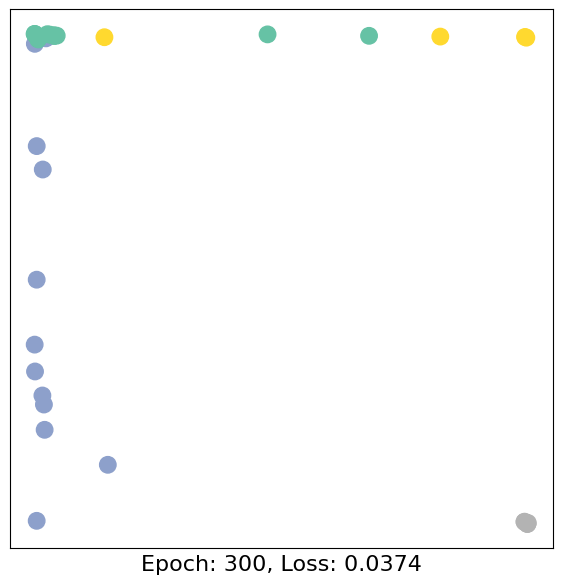

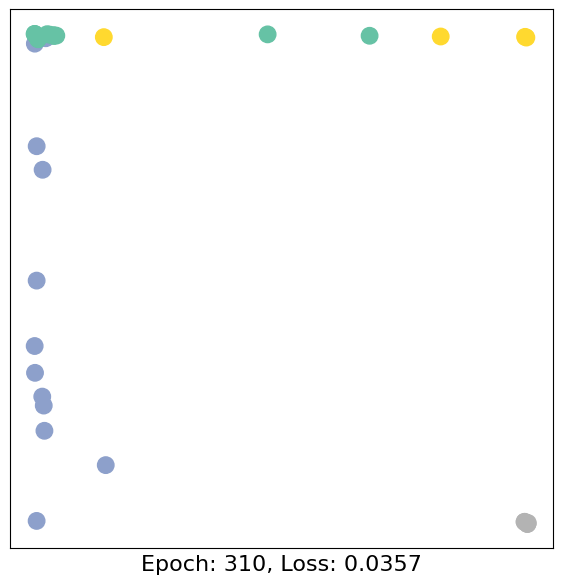

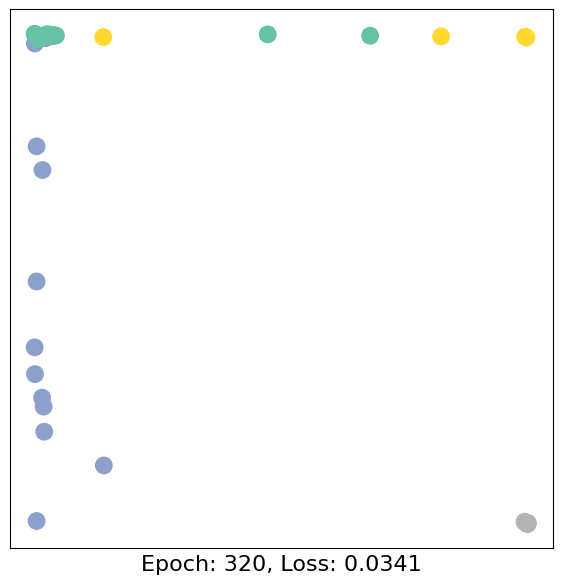

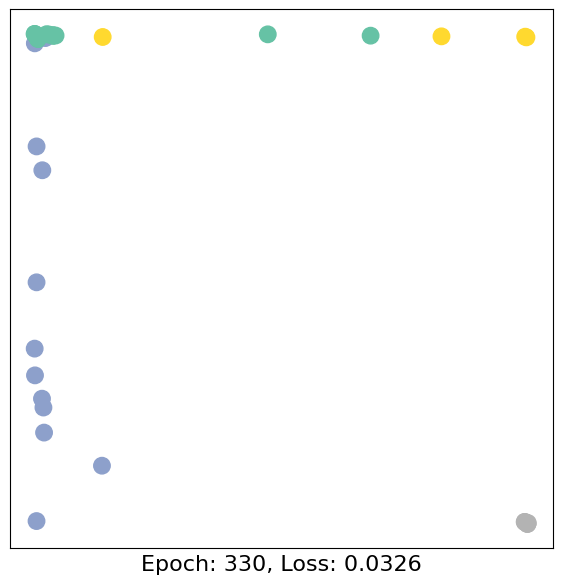

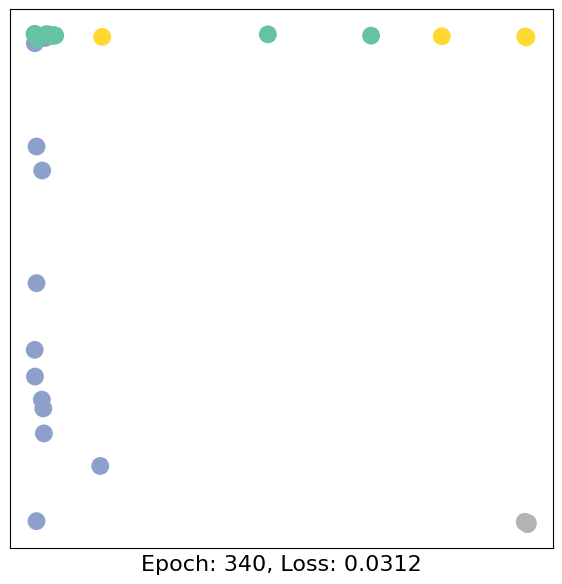

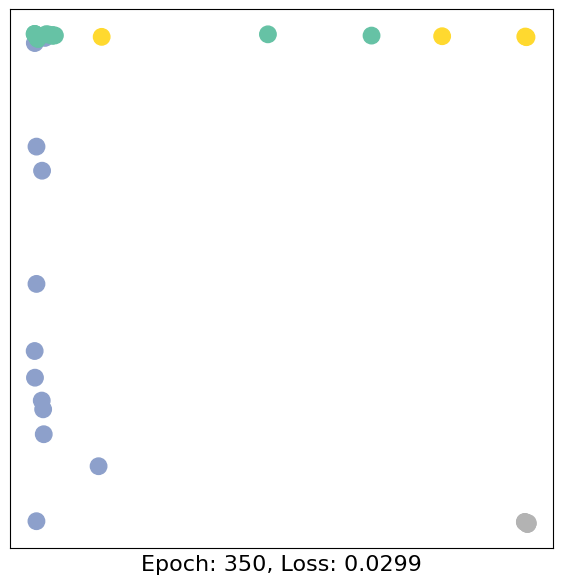

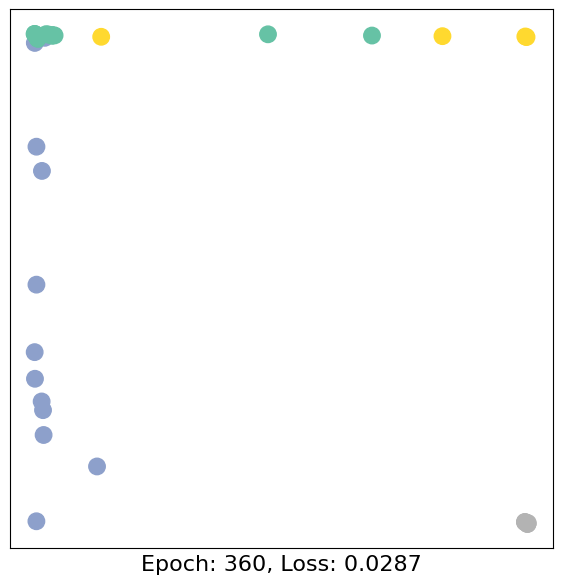

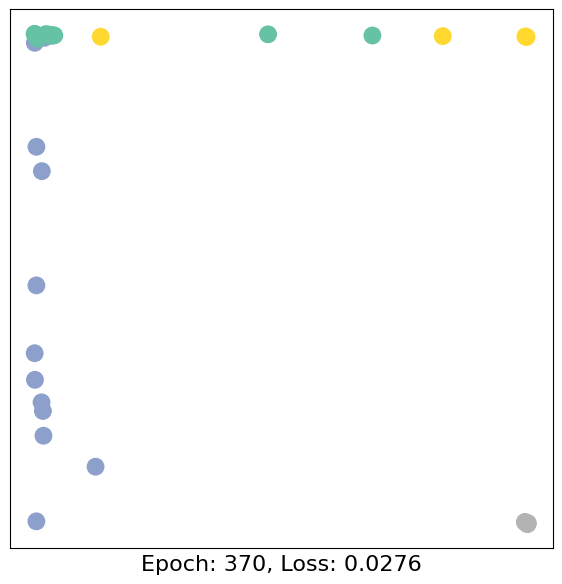

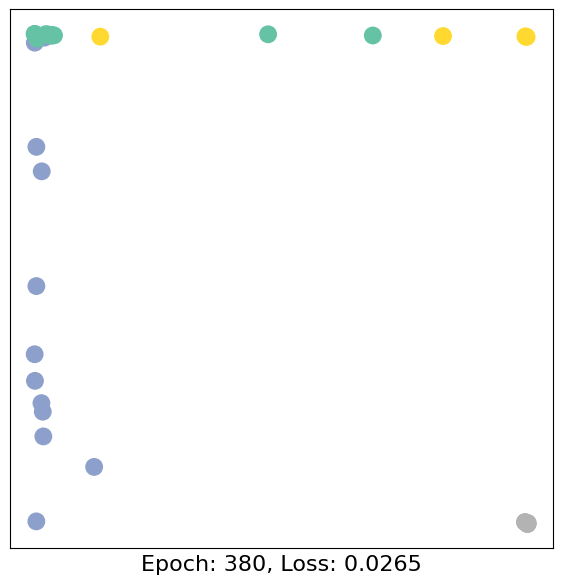

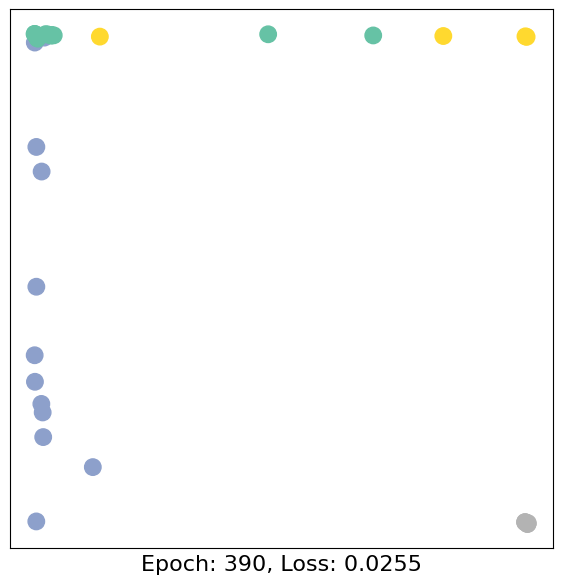

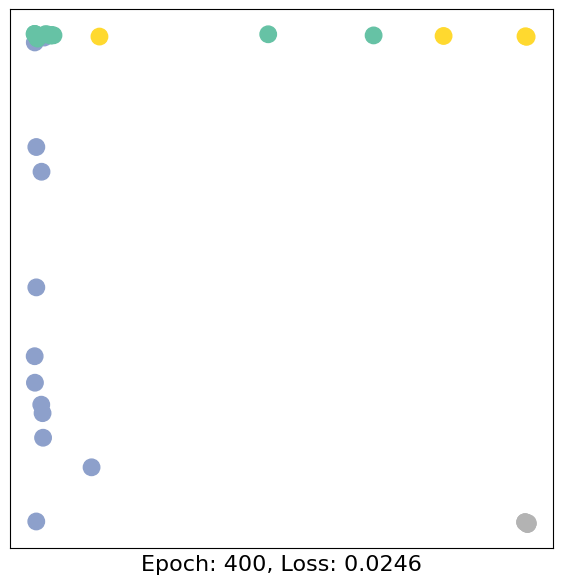

In [35]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [41]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=140, c=color, cmap="Set2")
    plt.show()

In [43]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [44]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [67]:
data = dataset[0]
print(data)
print('============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [69]:
# まずはグラフの構造を考慮しない、ノード特徴量のみでノード分類を行ってみる
# つまり、GNNを使っていない

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x


model = MLP(hidden_channels=16)
model

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)

In [70]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()

    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

Epoch 001, Loss: 1.9609
Epoch 002, Loss: 1.9558
Epoch 003, Loss: 1.9485
Epoch 004, Loss: 1.9413
Epoch 005, Loss: 1.9297
Epoch 006, Loss: 1.9266
Epoch 007, Loss: 1.9124
Epoch 008, Loss: 1.9024
Epoch 009, Loss: 1.8985
Epoch 010, Loss: 1.8849
Epoch 011, Loss: 1.8753
Epoch 012, Loss: 1.8684
Epoch 013, Loss: 1.8483
Epoch 014, Loss: 1.8465
Epoch 015, Loss: 1.8115
Epoch 016, Loss: 1.8143
Epoch 017, Loss: 1.7900
Epoch 018, Loss: 1.7985
Epoch 019, Loss: 1.7639
Epoch 020, Loss: 1.7383
Epoch 021, Loss: 1.7229
Epoch 022, Loss: 1.7452
Epoch 023, Loss: 1.7000
Epoch 024, Loss: 1.6855
Epoch 025, Loss: 1.6691
Epoch 026, Loss: 1.6479
Epoch 027, Loss: 1.6284
Epoch 028, Loss: 1.5960
Epoch 029, Loss: 1.5562
Epoch 030, Loss: 1.5396
Epoch 031, Loss: 1.5488
Epoch 032, Loss: 1.5224
Epoch 033, Loss: 1.4665
Epoch 034, Loss: 1.4885
Epoch 035, Loss: 1.4399
Epoch 036, Loss: 1.4035
Epoch 037, Loss: 1.4265
Epoch 038, Loss: 1.3742
Epoch 039, Loss: 1.3742
Epoch 040, Loss: 1.3391
Epoch 041, Loss: 1.3089
Epoch 042, Loss:

In [71]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


In [75]:
# 今度はGNNを使ってみる

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=16)
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

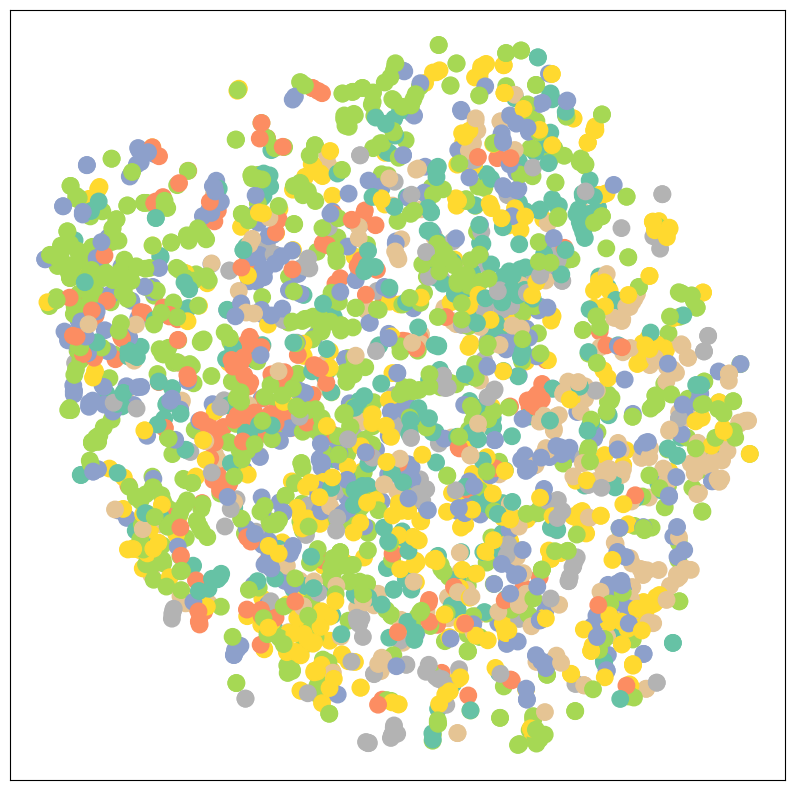

In [76]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [77]:
model = GCN(hidden_channels=16)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()

    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

Epoch 001, Loss: 1.9465
Epoch 002, Loss: 1.9419
Epoch 003, Loss: 1.9363
Epoch 004, Loss: 1.9290
Epoch 005, Loss: 1.9199
Epoch 006, Loss: 1.9140
Epoch 007, Loss: 1.9079
Epoch 008, Loss: 1.8992
Epoch 009, Loss: 1.8876
Epoch 010, Loss: 1.8764
Epoch 011, Loss: 1.8656
Epoch 012, Loss: 1.8626
Epoch 013, Loss: 1.8460
Epoch 014, Loss: 1.8329
Epoch 015, Loss: 1.8225
Epoch 016, Loss: 1.8167
Epoch 017, Loss: 1.7995
Epoch 018, Loss: 1.7878
Epoch 019, Loss: 1.7716
Epoch 020, Loss: 1.7568
Epoch 021, Loss: 1.7563
Epoch 022, Loss: 1.7342
Epoch 023, Loss: 1.7092
Epoch 024, Loss: 1.7015
Epoch 025, Loss: 1.6671
Epoch 026, Loss: 1.6757
Epoch 027, Loss: 1.6609
Epoch 028, Loss: 1.6355
Epoch 029, Loss: 1.6339
Epoch 030, Loss: 1.6102
Epoch 031, Loss: 1.5964
Epoch 032, Loss: 1.5721
Epoch 033, Loss: 1.5570
Epoch 034, Loss: 1.5445
Epoch 035, Loss: 1.5093
Epoch 036, Loss: 1.4889
Epoch 037, Loss: 1.4776
Epoch 038, Loss: 1.4704
Epoch 039, Loss: 1.4263
Epoch 040, Loss: 1.3972
Epoch 041, Loss: 1.3873
Epoch 042, Loss:

In [78]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


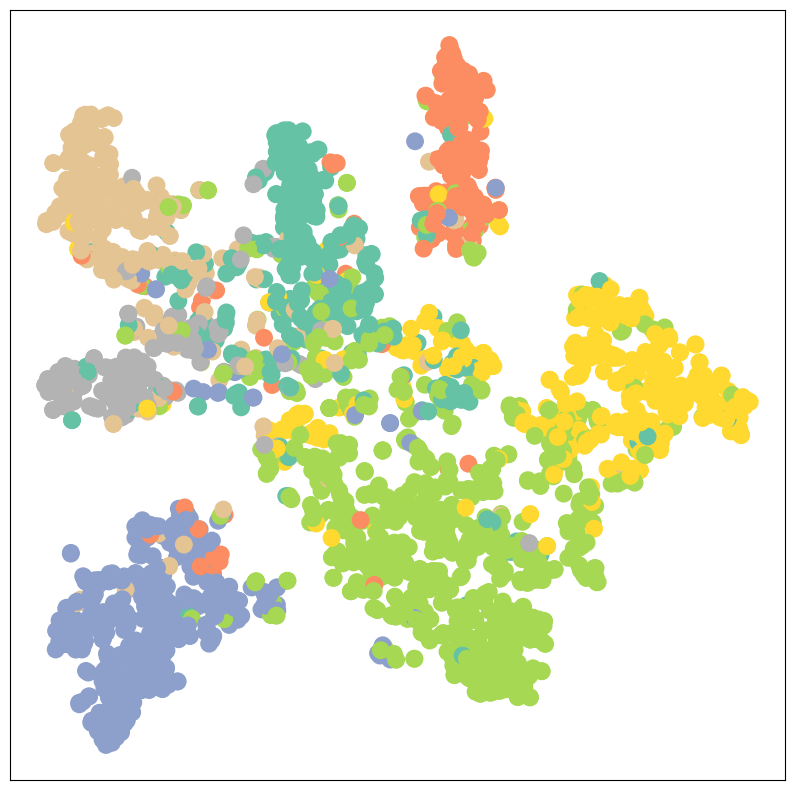

In [79]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [81]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [82]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [85]:
data = dataset[0]
print(data)
print('============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [86]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [110]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2662], x=[1203, 7], edge_attr=[2662, 4], y=[64], batch=[1203], ptr=[65])
Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2490], x=[1130, 7], edge_attr=[2490, 4], y=[64], batch=[1130], ptr=[65])
Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 842], x=[381, 7], edge_attr=[842, 4], y=[22], batch=[381], ptr=[23])


/Users/shuomura/Library/Caches/pypoetry/virtualenvs/ml-sandbox-br58J_x6-py3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [106]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. node embedding
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. readout（node embedding -> graph embedding）
        x = global_mean_pool(x, batch)

        # 3. graph embedding -> graph label
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [113]:
list(train_loader)

[DataBatch(edge_index=[2, 2662], x=[1203, 7], edge_attr=[2662, 4], y=[64], batch=[1203], ptr=[65]),
 DataBatch(edge_index=[2, 2490], x=[1130, 7], edge_attr=[2490, 4], y=[64], batch=[1130], ptr=[65]),
 DataBatch(edge_index=[2, 842], x=[381, 7], edge_attr=[842, 4], y=[22], batch=[381], ptr=[23])]

In [112]:
model = GCN(hidden_channels=64)
optimize = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()
    correct = 0
    
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    
    return correct / len(loader.dataset)

for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.6467, Test Acc: